In [1]:
# Package Install: sentence-transformers
# Module Needed: request, json, pprint, bs4(Beautiful Soap), time,SentenceTransformer, Scipy.spatial, numpy, datetime, matplotlib


# Package Prerequisites

Make sure that you have the following python packages installed:
* ``` conda install requests ```

* ``` conda install json ```

* ``` conda install pprint ```

* ``` conda install bs4 ```

* ``` pip install lxml ```

* ``` conda install pytorch torchvision cudatoolkit=10.0 -c pytorch ```

* ``` pip install -U sentence-transformers ```

* ``` conda install scipy ```

* ``` conda install datetime ```

* ``` conda install matplotlib ```

In [2]:
#REHS 2020 
#Created by Dhruv Kumar
import requests
import json
import pprint
from bs4 import BeautifulSoup
import time


In [3]:
# New Package Install 
!pip install -U sentence-transformers



Defaulting to user installation because normal site-packages is not writeable


In [4]:

from sentence_transformers import SentenceTransformer
import scipy.spatial
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates

# Web scraping
The forum that we will be scraping is a discourse forum called The Bank of New Zealand. It discusses topics related to people's banking issues as well as any problems people encounter while using the Bank of New Zealand mobile app. The forum is moderately active and has a large number of posts.

In [5]:

# Initialize variables
i = 0
all_submissions = []
crawler_condition = True

# Define the base URL and headers for GitHub API
base_url = "https://api.github.com/orgs/YOUR_ORG/teams/YOUR_TEAM_SLUG/discussions"
headers = {
    "Accept": "application/vnd.github+json",
    "Authorization": "Bearer YOUR_TOKEN"  # Replace YOUR_TOKEN with your GitHub token
}

while crawler_condition:
    print(i)
    url = base_url + "?page=" + str(i)
    response = requests.get(url, headers=headers)
    raw_dictionary = response.json()
    
    # Print the raw response to debug
    print(raw_dictionary)
    
    # Check if there are discussions in the response
    if isinstance(raw_dictionary, list) and len(raw_dictionary) == 0:
        crawler_condition = False
        break
    elif isinstance(raw_dictionary, dict) and 'message' in raw_dictionary:
        print(f"Error: {raw_dictionary['message']}")
        break
    else:
        for submission in raw_dictionary:
            dic = {
                "id": submission.get("number", "N/A"),
                "title": submission.get("title", "N/A"),
                "slug": submission.get("html_url", "N/A"),
                "replies": submission.get("comments_count", 0),
                "created_at": submission.get("created_at", "")[:7],
                "views": "N/A",  # GitHub Discussions API does not provide view count
                "likes": submission.get("reactions", {}).get("+1", 0),
                "category_id": "N/A",  # Adjust based on your needs
                "question": submission.get("body", "N/A")
            }
            all_submissions.append(dic)
        i += 1


0
{'message': 'Bad credentials', 'documentation_url': 'https://docs.github.com/rest'}
Error: Bad credentials


In [6]:
# for a given post url (specified by a slug and id) it will return the question of the post
def get_forum_message(message):
    soup = BeautifulSoup(message,"lxml")   
    div = soup.find("div", {"itemprop": "articleBody"})
    submission_text = ''
    ht = div.findAll('p') 
    for i in ht:
        submission_text += i.get_text()  
    return submission_text

Now we use the slugs and ids from all_submissions to create urls. We use the urls to get the message(question) of the post. Note that there is a time.sleep function because if we try fetching too quickly from the website, it will not let us, and return a None type. Thus, the below code might take 5-10 minutes. If you get an error that states that there is a None type, try changing the input for ``` time.sleep() ```

In [7]:

for i in range(len(all_submissions)):
    submission = all_submissions[i]
    topic_url = ("https://community.bnz.co.nz/t/" + submission["slug"] + '/' + str(submission["id"]))
    print(str(i) + " "+ topic_url)
    response = requests.get(topic_url)
    message = response.text
    question = get_forum_message(message)
    submission["question"] = question
    if i % 10 == 0:
        time.sleep(5.0)

At this point, we have a dictionary called all_submissions which is an array of dictionaries. To clarify further, each element in all_submissions is a dictionary. Each disctionary represents all the data about one post. For example, the first element in all_submissions is a dictionary with the information about the first post. The dictionary contains data such as the number of views, likes, the slug, the id number, title, and question of the post.

# Recommender Model

Now that we have the question and title of the post (as well as other metadata), we can build a recommendation model. This model will return the top 5 posts that are most similar to the current post. 

In [8]:
topic_names = [x["title"] for x in all_submissions]
questions = [x["question"] for x in all_submissions]

In [9]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

You can make the recommendation system based on either the title of the post (topic_names) or the question (questions).
Note that creating the embeddings using the question will take much longer (approx 1 hour) compared to using the titles.
The below example uses the titles of the posts. To use the question themselves, change ```topic_names[i]``` to ```questions[i]```

In [10]:
embedings = []
for i in range(len(questions)):
    embedings.append(embedder.encode(topic_names[i]))
    print(str(i/len(questions)*100)+"%")

Now we calculate the cosine similarity between two vectors. Since we are using cosine similarity, a distance of 0 between the vectors means that they are the same. A distance of 1.0 means that they are orthogonal (very different). Note that we have used 1.0-dist as the metric. Thus 1.0 means the same and 0 means very different.

Distances is a 2D matrix with each vector compared to all other vectors

In [11]:
distances = []
for vector1 in embedings:
    temp = []
    for vector2 in embedings:
        dist = scipy.spatial.distance.cdist(vector1, vector2, "cosine")
        temp.append(1.0 - dist)
    distances.append(temp)

In [12]:
#returns the top N-1 elements in list1 (it finds the top N elements, but removes the first one because the first
#element is the same post (itself))

def Nmaxelements(list1, N): 
    final_list = [] 
    list1_copy = list1.copy() 

    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1_copy)):      
            if list1_copy[j] > max1: 
                max1 = list1_copy[j]; 

        list1_copy.remove(max1); 
        final_list.append([i,max1,topic_names[i]]) 

    return(final_list[1:])

In [13]:
recommendations = []
for i in range(len(questions)):
    recommendations.append(Nmaxelements(distances[i],6))

recommendations is a 2D array. Each element in recommendations is an array that contains the top 6 (top 5, because it removes itself,which is most similar to itself).

# Visulazing Data

We will now plot the number of posts created during each month on this forum

First, we convert the all_submissions dictionary into a 2D array called temp_submissions

In [14]:
temp_submissions = [] #2D array with information similar to that in all_submissions 
for i in all_submissions:
    submission = []
    submission.append(i["replies"])
    submission.append(i["views"])
    submission.append(i["likes"])
    submission.append(i["category_id"])
    submission.append(i["created_at"])
    temp_submissions.append(submission)

Next, we find the unique number of dates and sort them (earliest --> present)

In [15]:
dates = list(set([x[4] for x in temp_submissions])) #unique dates
dates = np.array(dates)
dates = np.sort(dates)

Now, we make a list postsADay, which countains the number of posts created on a specific month/year

In [16]:
postsADay = [0] * len(dates)
for i in temp_submissions:
    for j in range(len(dates)):
        if i[4] == dates[j]:
            postsADay[j] += 1
            

Mathplotlib needs a different format for the dates. Thus, we convert the dates in the array dates to matplotlib dates and append these newly formatted dates to pltdates.

In [17]:
pltdates = []
for i in dates:
    year = i[0:4]
    month = i[5:7]
    date = datetime.datetime(int(year),int(month),1)
    pltdates.append(matplotlib.dates.date2num(date))
    
    

Now we plot the dates using plt.plot_date
We use the linestyle = '-' to show a line graph, rather than simply a scatterplot

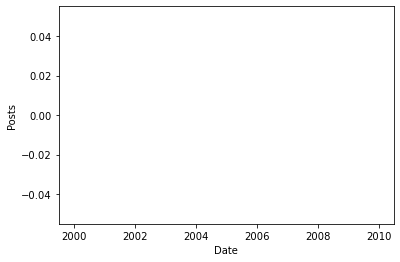

In [18]:
plt.plot_date(pltdates,postsADay, linestyle = '-')
plt.xlabel('Date')
plt.ylabel('Posts')
plt.show()